# Initalization

Many of these sections were heavily inspired by Sam Zorowitz. Modeled after analysis found here: https://github.com/mghneurotherapeutics/JNeurosci-ARC/blob/master/ARC_Analysis_FINAL.ipynb


In [1]:
import sys
sys.path.append('../src')
from surfer import Brain
from fmri import generate_task_regressors, plot_task_regressors
from utils import select_subjects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from fmri import plot_design_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor

# fmri timing info 
tr = 1.75
num_acq = 228
dt = .001 # upsampled regressor resolution

# Pick fmri subjects
subjects = select_subjects('fmri')

# folders
fsfast_path = '../data/derivatives/fmri_first_levels'
fmriprep_path = '../data/derivatives/fmriprep'

# Load behavior data
behavior = pd.read_csv('../data/derivatives/behavior/group_data.tsv', 
                       sep='\t')
behavior = behavior[behavior.modality == 'fmri']

# remove excluded trials 
exclusions = ['error', 'post_error', 'no_response', 'fast_rt']
behavior = behavior[behavior[exclusions].sum(axis=1) == 0]

# First Levels

## Make Task Paradigm Files 

Here I make regressors for the congruent and incongruent conditions. I make both full duration boxcar regressors and variable rt epoch regressors to look at RT independent and dependent effects. Methods and considerations based on the following papers:

- Tal Yarkoni's Blog Post on time on task implications: https://www.talyarkoni.org/blog/2010/06/16/time-on-task-effects-in-fmri-research-why-you-should-care/
- Yarkoni paper related to above blog post: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2622763/
- Grinbad Paper explaining variable RT epoch method as most ideal method for accounting for time on task effects: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2654219/

Note that the variable RT epoch model assumes the process is well approximated by a diffusion model.

In [2]:
for subject in subjects:
    print(subject)
    
    sub_behavior = behavior[behavior.participant_id == subject]
    sub_behavior['tt'] = sub_behavior.trial_type.astype('category').cat.codes + 1
    sub_behavior['weight'] = 1.0
    
    # extract behavior information
    for typ in ['base', 'rt']:
        if typ == 'base':
            columns = ['onset', 'tt', 'duration', 'weight', 'trial_type']
        else:
            columns = ['onset', 'tt', 'response_time', 'weight', 'trial_type']
        
        df = sub_behavior[columns]
        
        # save the regressors
        f = '%s/%s/msit/001/%s.par'
        df.to_csv(f % (fsfast_path, subject, typ), header=False, sep='\t',
                  index=False)
        
        
print('Done!') 

sub-hc001


/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


sub-hc002
sub-hc003
sub-hc004
sub-hc005
sub-hc006
sub-hc007
sub-hc008
sub-hc009
sub-hc010
sub-hc011
sub-hc012
sub-hc013
sub-hc014
sub-hc015
sub-hc016
sub-hc017
sub-hc019
sub-hc021
sub-hc022
sub-hc023
sub-hc024
sub-hc025
sub-hc026
sub-hc027
sub-hc028
sub-hc029
sub-hc030
sub-hc031
sub-hc032
sub-hc033
sub-hc034
sub-hc035
sub-hc036
sub-hc038
sub-hc041
sub-hc042
sub-hc044
sub-pp001
sub-pp002
sub-pp003
sub-pp004
sub-pp005
sub-pp006
sub-pp007
sub-pp008
sub-pp009
sub-pp010
sub-pp011
sub-pp012
sub-pp013
sub-pp014
sub-pp015
sub-pp016
Done!


## Make Motion Timepoint Censors

We use only functional displacement based motion timepoint censoring (and no motion regressors) as determined in <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3895106/"> Siegel 2013 </a>. We use their threshold of 0.9 mm though we recognize this was not a global recommendation, but it is used here as a reasonable value without further investigation.

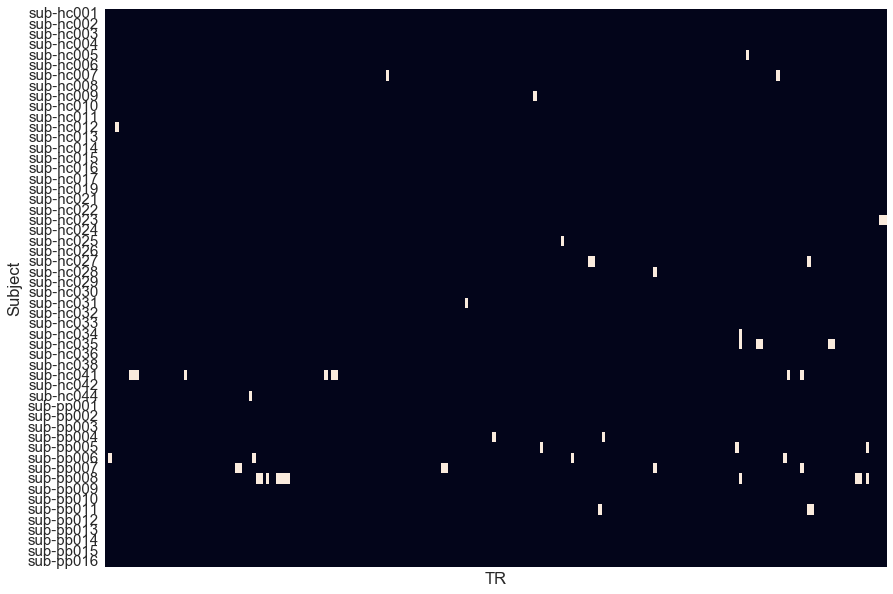

In [3]:
fd = 0.9
fds = np.zeros((len(subjects), num_acq))

for i, subject in enumerate(subjects):
    
    f = '%s/%s/func/%s_task-msit_bold_confounds.tsv'
    confounds = pd.read_csv(f % (fmriprep_path, subject, subject),
                            sep='\t', na_values='n/a')
    
    # determine fd censor indices 
    fd_ix = np.where(confounds.FramewiseDisplacement >= fd)[0]
    fds[i, fd_ix] = 1
    
    # save censor indices
    f = '%s/%s/msit/001/fd_censor.par' 
    np.savetxt(f % (fsfast_path, subject), fd_ix, fmt='%d')
        
# Plot censor heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(fds, cbar=False)
plt.xticks(())
plt.yticks(np.arange(len(subjects)) + .5, subjects, rotation=0)
plt.xlabel('TR')
plt.ylabel('Subject')
plt.show()

## Run 1st Levels

### Set Up the Analysis 

In [4]:
%%bash

# Source freesurfer v6
export FREESURFER_HOME=/usr/local/freesurfer/stable6_0_0
. /usr/local/freesurfer/stable6_0_0/SetUpFreeSurfer.sh
export SUBJECTS_DIR=/autofs/space/cassia_001/users/matt/msit/data/derivatives/freesurfer

# get into fsfast directory
export FSFAST=../data/derivatives/fmri_first_levels
cd $FSFAST

# set up the analyses
types="base rt"
hemis="lh rh"

for type in $types
do
    for hemi in $hemis 
    do
        mkanalysis-sess -analysis $type.$hemi \
                        -surface fsaverage $hemi \
                        -event-related \
                        -fsd msit \
                        -fwhm 4 \
                        -per-run \
                        -TR 1.75 \
                        -refeventdur 1.75 \
                        -paradigm $type.par \
                        -nconditions 2 \
                        -spmhrf 0 \
                        -polyfit 0 \
                        -hpf 0.01 \
                        -nskip 4 \
                        -tpexclude fd_censor.par \
                        -force
    done
    
    mkanalysis-sess -analysis $type.mni305 \
                    -mni305 \
                    -event-related \
                    -fsd msit \
                    -fwhm 4 \
                    -per-run \
                    -TR 1.75 \
                    -refeventdur 1.75 \
                    -paradigm $type.par \
                    -nconditions 2 \
                    -spmhrf 0 \
                    -polyfit 0 \
                    -hpf 0.01 \
                    -nskip 4 \
                    -tpexclude fd_censor.par \
                    -force
done

Setting TER to 0.050000
Setting TimeWindow to 40.000000
Setting PreStim    to 0
Setting PostStim   to 40.000000
# FSBUILD freesurfer-Linux-centos6_x86_64-stable-pub-v6.0.0-2beb96c
# MKAVERSION $Id: mkanalysis-sess,v 1.78 2015/12/10 22:51:30 zkaufman Exp $
# MKACMD /usr/local/freesurfer/stable6_0_0/fsfast/bin/mkanalysis-sess -analysis base.lh -surface fsaverage lh -event-related -fsd msit -fwhm 4 -per-run -TR 1.75 -refeventdur 1.75 -paradigm base.par -nconditions 2 -spmhrf 0 -polyfit 0 -hpf 0.01 -nskip 4 -tpexclude fd_censor.par -force
# DATE Thu Jan 18 16:45:20 EST 2018

analysis base.lh
mcstem fmcpr
fsd msit
TR 1.75
RegDOF 6
PerSession 0
RawSpace surface fsaverage lh
mask brain
RawFWHM 4
RawSTC none
nSliceGroups 1
UseB0DC 0
ApplySubCortMask 1
inorm 100
acfbins 30
fixacf  1
acffwhm 20
acfsvd  0
designtype event-related
tpexclude fd_censor.par
nskip 4
polyfit 0
HPFCutoffHz 0.01
HeteroGCor 0
nconditions 2
parname base.par
RefEventDur 1.75
timewindow 40.000000
prestim 0
TER 0.050000
spmhr

### Compute Contrast Matrices

In [5]:
%%bash

# Source freesurfer v6
export FREESURFER_HOME=/usr/local/freesurfer/stable6_0_0
. /usr/local/freesurfer/stable6_0_0/SetUpFreeSurfer.sh
export SUBJECTS_DIR=/autofs/space/cassia_001/users/matt/msit/data/derivatives/freesurfer

# get into fsfast directory
export FSFAST=../data/derivatives/fmri_first_levels
cd $FSFAST

# set up the analyses
types="base rt"
spaces="lh rh mni305"

for type in $types
do
    for space in $spaces
    do
        mkcontrast-sess -analysis $type.$space\
                        -contrast incongruent \
                        -a 2
                        
        mkcontrast-sess -analysis $type.$space\
                        -contrast congruent \
                        -a 1
                        
        mkcontrast-sess -analysis $type.$space\
                        -contrast incongruent-congruent \
                        -a 2 -c 1
                        
    done
    
done

INFO: Found 2 Non-Null Conditions
INFO: Found 1 Delays
Condition Weights: 0 1.00000000000000000000
mkcontrast2 -config base.lh/incongruent.config -anadir base.lh -wcond 0 1.00000000000000000000 -sumconds -o base.lh/incongruent.mat -wdelay 1 -no-octave
  $Id: mkcontrast2,v 1.3 2016/03/11 23:46:48 greve Exp $
cmtxfile  base.lh/incongruent.mat
nconds    2,  wcond  0 1.00000000000000000000
ndelays   1, wdelay 1
ndelays   1, wpsa   
sumconds  1
sumdelays 0
nircorr   0
TER       0.050000
rdelta    
rtau      
  cmtxfile  base.lh/incongruent.mat
  monly  0
  NCond   2
  WCond   0 1.00000000000000000000
  NDelay  1
  WDelay  1
  TER         0.050000
  sumconds   1
  sumdelays  0
  nircorr  0
  TPreStim  0
  RmPreStim  0
  rdelta     0 0
  rtau       0 0
  ndelays    1
  CNorm      1
  setwdelay  0
  setwcond   0
Matlab file is /tmp/mkcontrast2.127043.m
MATLAB is selecting SOFTWARE OPENGL rendering.

                            < M A T L A B (R) >
                  Copyright 1984-2015 The MathW

com.mathworks.util.ShutdownRuntimeException: Java is shutting down
	at com.mathworks.services.Prefs.nativeGetPreferencesDirectory(Native Method)
	at com.mathworks.services.Prefs.getPropertyDirectory(Prefs.java:198)
	at com.mathworks.services.binding.MatlabKeyBindingPreferenceUtils.resolveToPrefDir(MatlabKeyBindingPreferenceUtils.java:112)
	at com.mathworks.services.binding.MatlabKeyBindingPreferences.getModifiedDefaultFile(MatlabKeyBindingPreferences.java:213)
	at com.mathworks.services.binding.MatlabKeyBindingPreferences.resolveModifiedDefaultFilesFromPrefs(MatlabKeyBindingPreferences.java:116)
	at com.mathworks.services.binding.MatlabKeyBindings.initializeFromPrefs(MatlabKeyBindings.java:717)
	at com.mathworks.services.binding.MatlabKeyBindings.<clinit>(MatlabKeyBindings.java:590)
	at com.mathworks.widgets.debug.DebuggerManager$ActionShell.<init>(DebuggerManager.java:194)
	at com.mathworks.widgets.debug.DebuggerManager$ActionShell.<init>(DebuggerManager.java:190)
	at com.mathworks.wi

### Fit the GLM

In [8]:
%%bash

# Source freesurfer v6
export FREESURFER_HOME=/usr/local/freesurfer/stable6_0_0
. /usr/local/freesurfer/stable6_0_0/SetUpFreeSurfer.sh
export SUBJECTS_DIR=/autofs/space/cassia_001/users/matt/msit/data/derivatives/freesurfer

# get into fsfast directory
export FSFAST=../data/derivatives/fmri_first_levels
cd $FSFAST

# set up the analyses
types="base rt"
spaces="lh rh mni305"

for type in $types
do
    for space in $spaces
    do
        selxavg3-sess -analysis $type.$space -sf subjects -no-preproc -overwrite
    done
    
done

Surface data fsaverage lh
--------------------------------------------------------------
selxavg3-sess logfile is /autofs/space/cassia_001/users/matt/msit/data/derivatives/fmri_first_levels/log/selxavg3-sess-msit-base.lh-180119111022.log
--------------------------------------------------------------
selxavg3-sess log file
/usr/local/freesurfer/stable6_0_0/fsfast/bin/selxavg3-sess
-analysis base.lh -sf subjects -no-preproc -overwrite
$Id: selxavg3-sess,v 1.68 2016/05/10 03:24:18 greve Exp $
uid=3950117(mwb27) gid=3950117(mwb27) groups=3950117(mwb27),973(docker),1047(iliad)
/autofs/space/cassia_001/users/matt/msit/data/derivatives/fmri_first_levels
Linux cassia.nmr.mgh.harvard.edu 3.10.0-693.11.1.el7.x86_64 #1 SMP Mon Dec 4 23:52:40 UTC 2017 x86_64 x86_64 x86_64 GNU/Linux
Fri Jan 19 11:10:23 EST 2018
-------------------------------------------
1/54 /autofs/space/cassia_001/users/matt/msit/data/derivatives/fmri_first_levels/sub-hc001 
Fri Jan 19 11:10:23 EST 2018
anadir = /autofs/space/ca

### Visualize Design Matrix

In [9]:
sns.set(style='whitegrid', font_scale=2)
plt.close('all')

for subject in subjects:

    for typ in ['base', 'rt']:
        
        fig = plot_design_matrix(fsfast_path, subject, typ)
        f = '%s/%s/msit/%s_design_matrix.png'
        fig.savefig(f % (fsfast_path, subject, typ))
        plt.close(fig)
        
print('Done!')

/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/numpy/lib/npyio.py:893: UserWarning: loadtxt: Empty input file: "../data/derivatives/fmri_first_levels/sub-hc001/msit/001/fd_censor.par"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)
/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/numpy/lib/npyio.py:893: UserWarning: loadtxt: Empty input file: "../data/derivatives/fmri_first_levels/sub-hc002/msit/001/fd_censor.par"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)
/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/numpy/lib/npyio.py:893: UserWarning: loadtxt: Empty input file: "../data/derivatives/fmri_first_levels/sub-hc003/msit/001/fd_censor.par"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)
/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/numpy/lib/npyio.py:893: UserWarn

/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/numpy/lib/npyio.py:893: UserWarning: loadtxt: Empty input file: "../data/derivatives/fmri_first_levels/sub-pp010/msit/001/fd_censor.par"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)
/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/numpy/lib/npyio.py:893: UserWarning: loadtxt: Empty input file: "../data/derivatives/fmri_first_levels/sub-pp012/msit/001/fd_censor.par"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)
/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/numpy/lib/npyio.py:893: UserWarning: loadtxt: Empty input file: "../data/derivatives/fmri_first_levels/sub-pp013/msit/001/fd_censor.par"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)
/autofs/space/cassia_001/users/matt/software/anaconda2.7/envs/msit/lib/python2.7/site-packages/numpy/lib/npyio.py:893: UserWarn

Done!


## Visualize Results

In [10]:
SUBJECTS_DIR = '/autofs/space/cassia_001/users/matt/msit/data/derivatives/freesurfer'
for subject in subjects:

    for typ in ['base', 'rt']:
        
        # plot sig
        brain = Brain('fsaverage', 'split', 'inflated', views=['lat', 'med'],
                      subjects_dir=SUBJECTS_DIR)
        
        for hemi in ['lh', 'rh']:
            f = '%s/%s/msit/%s.%s/incongruent-congruent/sig.nii.gz' % (fsfast_path, subject,
                                                 typ, hemi)
            brain.add_overlay(f, hemi=hemi, min=1.3, max=5)
        f = '%s/%s/msit/%s_sig.png' % (fsfast_path, subject, typ) 
        brain.save_image(f)
        i
        brain = Brain('fsaverage', 'split', 'inflated', views=['lat', 'med'],
                      subjects_dir=SUBJECTS_DIR)
        
        for hemi in ['lh', 'rh']:
            f = '%s/%s/msit/%s.%s/incongruent-congruent/t.nii.gz' % (fsfast_path, subject,
                                                 typ, hemi)
            brain.add_overlay(f, hemi=hemi, min=2, max=5)
        f = '%s/%s/msit/%s_t.png' % (fsfast_path, subject, typ) 
        brain.save_image(f)
        
        brain = Brain('fsaverage', 'split', 'inflated', views=['lat', 'med'],
                      subjects_dir=SUBJECTS_DIR)
        
        for hemi in ['lh', 'rh']:
            f = '%s/%s/msit/%s.%s/incongruent-congruent/ces.nii.gz' % (fsfast_path, subject,
                                                 typ, hemi)
            brain.add_overlay(f, hemi=hemi, min=.3, max=1)
        f = '%s/%s/msit/%s_ces.png' % (fsfast_path, subject, typ) 
        brain.save_image(f)

print('Done!')

Done!


# Group Levels